# Generative Adversarial Network (GAN)

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda'

In [28]:
def accuracy(net, dl):
    acc = 0.
    for x,t in dl:
        y = net(x)
        k = torch.argmax(y, dim=-1)
        acc += torch.sum(k==t)
    return acc.item() / len(dl.dataset)

In [29]:
# PyTorch 1.7 includes a layer called Unflatten, which undoes what Flatten does.
# If your torch version is <1.7, then you can use this class in its place.
class Unflatten(nn.Module):
    '''
     Unflatten(dim, unflatten_size)
     
     Reshapes a DxN tensor to Dx(*unflatten_size).
     The first argument, dim, is actually IGNORED, but is included here
     for compatibility with nn.Unflatten.
     
     Usage:
       x = torch.random(10,50)  # x is 10x50
       lyr = Unflatten(1, (2,5,5))
       y = lyr(x)   # produces y with dimensions (10,2,5,5)
    '''
    def __init__(self, dim, shape):
        super().__init__()
        self.start_dim = dim
        self.shape = shape
        
    def forward(self, x):
        return torch.reshape(x, (x.shape[0], *self.shape))

# Dataset

In [30]:
# Use this for fully-connected network
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [31]:
# Use this for CNN
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            ]))

## Process

In [32]:
#ds_train = torch.utils.data.Subset(ds_train_full, range(5000))
ds_train = ds_train_full

In [33]:
x,t = ds_train.__getitem__(0)

In [34]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [35]:
# Batched, for training
batch_size_train = 128
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

In [36]:
x,t = next(iter(train_dl))

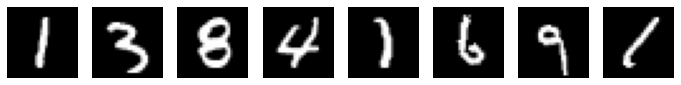

In [37]:
x,t = next(iter(train_dl))
draw(x[:8])

# initial weight
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

# GAN classes

## CNN GAN
This CNN GAN does not work for some reason. It trains, etc, but does not generate digit-like images.

In [38]:
class ganC(nn.Module):
    def __init__(self):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        self.Number_Channel = 1
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            
            nn.Conv2d(self.Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            
            nn.Tanh()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        return self.G(z)
    
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            for x,t in dl:
                real_data = x.to(device)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                fake_data = self.G(noise)
                label.fill_(0.) # fake label
                output = self.D(fake_data.detach()).view(-1) 
                
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

## Fully-connected GAN

# Train it and test it

In [39]:
net = ganC()

100%|██████████| 5/5 [03:25<00:00, 41.15s/it]


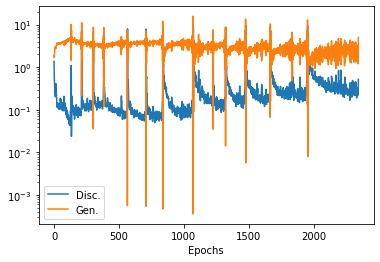

In [40]:
net.learn(train_dl, epochs=5, lr=0.0001)

In [41]:
torch.save(net.to('cpu'), 'gan_demo.pt')
#net = torch.load('gan_demo.pt', map_location=device); net.to(device);
#net = torch.load('gan_cnn_demo.pt', map_location=device); net.to(device);
net.to(device);

torch.Size([128, 1, 1, 1])


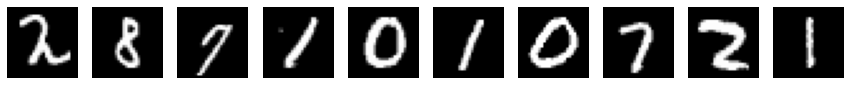

In [42]:
x,t = next(iter(train_dl))
y = net.discriminate(x.to(device))
print(y.shape)
draw(x[:10]);

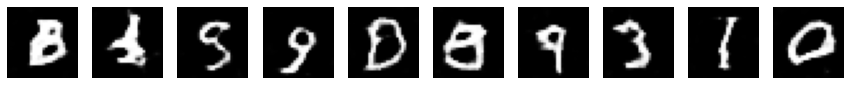

In [43]:
x = net.generate(n=10).to(device)
y = net(x)
draw(x[:10])